(np.float64(-0.5), np.float64(1190.5), np.float64(1253.5), np.float64(-0.5))

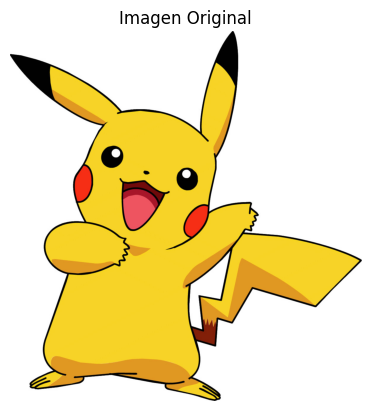

In [2]:
import cv2
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import time

# Cargar imagen
img = cv2.imread("pikachu.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title("Imagen Original")
plt.axis("off")


(np.float64(-0.5), np.float64(1190.5), np.float64(1253.5), np.float64(-0.5))

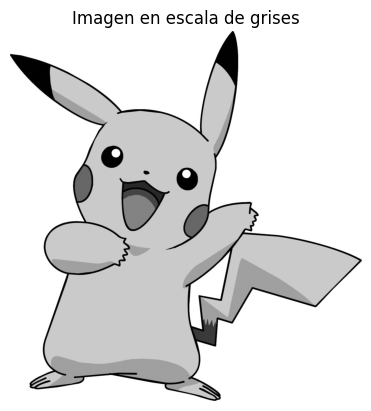

In [2]:
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

plt.imshow(img_gray, cmap='gray')
plt.title("Imagen en escala de grises")
plt.axis("off")


In [3]:
import numpy as np
import time

def sobel_cpu(img_gray):
    h, w = img_gray.shape
    output = np.zeros((h, w), dtype=np.float32)

    # Kernels Sobel
    Kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])

    Ky = np.array([[-1, -2, -1],
                   [ 0,  0,  0],
                   [ 1,  2,  1]])

    # Bucle manual
    for y in range(1, h-1):
        for x in range(1, w-1):

            # matriz 3x3 alrededor del pixel
            region = img_gray[y-1:y+2, x-1:x+2]

            # convolución manual
            Gx = np.sum(region * Kx)
            Gy = np.sum(region * Ky)

            # magnitud del gradiente
            output[y, x] = np.sqrt(Gx**2 + Gy**2)

    return output

# --- Medir tiempo CPU ---
start = time.time()
sobel_cpu_output = sobel_cpu(img_gray)
end = time.time()

print(f"Tiempo CPU (Sobel): {end - start:.4f} segundos")

# normalizar para mostrar
sobel_cpu_norm = (sobel_cpu_output / sobel_cpu_output.max()) * 255
sobel_cpu_norm = sobel_cpu_norm.astype(np.uint8)


Tiempo CPU (Sobel): 15.5412 segundos


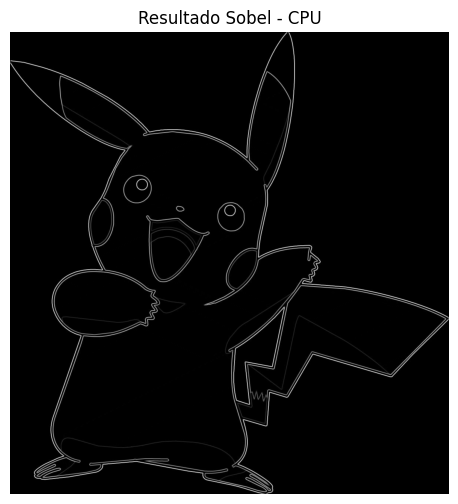

In [4]:
# --- Mostrar resultado Sobel CPU ---
plt.figure(figsize=(6,6))
plt.imshow(sobel_cpu_norm, cmap='gray')
plt.title("Resultado Sobel - CPU")
plt.axis("off")
plt.show()


##Procesamiento con GPU

(np.float64(-0.5), np.float64(1190.5), np.float64(1253.5), np.float64(-0.5))

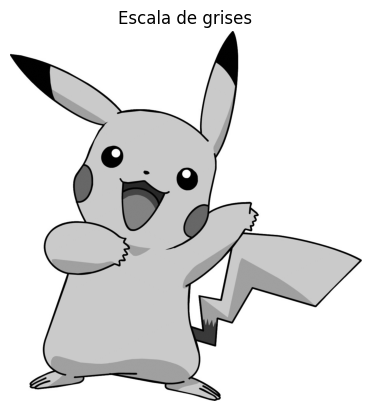

In [6]:
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

plt.imshow(img_gray, cmap='gray')
plt.title("Escala de grises")
plt.axis("off")


In [9]:
img_gpu = cp.asarray(img_gray)
height, width = img_gpu.shape

out_gpu = cp.zeros((height, width), dtype=cp.float32)

sobel_kernel = cp.RawKernel(r"""
extern "C" __global__
void sobel(const unsigned char* img, float* out, int width, int height) {

    int x = blockDim.x * blockIdx.x + threadIdx.x;
    int y = blockDim.y * blockIdx.y + threadIdx.y;

    if (x < 1 || x >= (width-1) || y < 1 || y >= (height-1))
        return;

    int Gx =
        -1 * img[(y-1)*width + (x-1)] +  1 * img[(y-1)*width + (x+1)] +
        -2 * img[(y)*width   + (x-1)] +  2 * img[(y)*width   + (x+1)] +
        -1 * img[(y+1)*width + (x-1)] +  1 * img[(y+1)*width + (x+1)];

    int Gy =
        -1 * img[(y-1)*width + (x-1)] + -2 * img[(y-1)*width + (x)] + -1 * img[(y-1)*width + (x+1)] +
         1 * img[(y+1)*width + (x-1)] +  2 * img[(y+1)*width + (x)] +  1 * img[(y+1)*width + (x+1)];

    float g = sqrtf((float)(Gx*Gx + Gy*Gy));

    out[y * width + x] = g;
}
""", "sobel")


In [10]:
threads = (16, 16)
blocks = ((width + threads[0] - 1)//threads[0],
          (height + threads[1] - 1)//threads[1])

start = time.time()

sobel_kernel(
    blocks, threads,
    (
        img_gpu,
        out_gpu,
        np.int32(width),
        np.int32(height)
    )
)

cp.cuda.Stream.null.synchronize()
end = time.time()

print(f"Tiempo GPU (Sobel CUDA): {end - start:.4f} segundos")

# Pasar a CPU
sobel_gpu_output = cp.asnumpy(out_gpu)

# Normalizar
sobel_gpu_norm = (sobel_gpu_output / sobel_gpu_output.max()) * 255
sobel_gpu_norm = sobel_gpu_norm.astype(np.uint8)


Tiempo GPU (Sobel CUDA): 0.5474 segundos


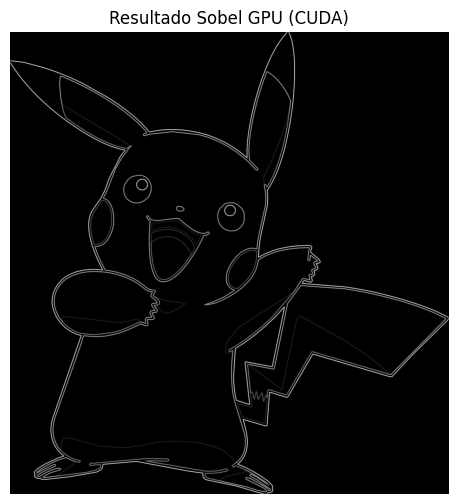

In [11]:
plt.figure(figsize=(6,6))
plt.imshow(sobel_gpu_norm, cmap='gray')
plt.title("Resultado Sobel GPU (CUDA)")
plt.axis("off")
plt.show()
